In [1]:
# add parent folder to search directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from keras import layers, optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Dropout

from MR import MaxeyRiley
from flow_interpolater import flow_interpolater
from matplotlib import animation, rc
from matplotlib.patches import Circle
from IPython.display import HTML
from predictors import rnn_predict, fullmr_predict, slowmanifold_predict

In [4]:
plt.rc('text', usetex=True)

In [5]:
class rnn_model(object):
    
    def __init__(self, input_dims, output_dims, lstm_units=128, dense_units=64,
                input_mean=0, input_std=1):

        self.input_dims = input_dims
        self.output_dims = output_dims
        self.lstm_units = lstm_units
        self._build_model(lstm_units, dense_units)
#         self._zero_states = [np.zeros(lstm_units,), np.zeros(lstm_units,)]
        self.input_mean = input_mean
        self.input_std = input_std
    
    def _build_model(self, lstm_units, dense_units):
    
        xi = layers.Input(shape=(None, self.input_dims))
        states0 = [layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))]
        
        lstm_layer = layers.recurrent.LSTM(lstm_units, input_shape=(1, self.input_dims), return_state=True)
        out, *states = lstm_layer(xi, initial_state=states0)
        out = layers.Dropout(.2)(out)
        out = layers.Dense(dense_units, activation='linear')(out)
        out = layers.Dropout(.2)(out)
        out = layers.Dense(2, activation='linear')(out)
        self.model = Model(inputs=[xi]+states0, outputs=[out]+states)
        self.model.compile(optimizer='adam', loss='mse')

    def load_weights(self, weights):
        self.model.load_weights(weights)      

    def predict(self, input_and_state):
        input_normal = (input_and_state[0] - self.input_mean)/self.input_std
        return self.model.predict([input_normal]+input_and_state[1:])

    def predict0(self, inputs):
        # run prediction without providing the most recent hidden states (assuming to be zero)
        input_normal = (inputs - self.input_mean)/self.input_std
        states_shape = (input_normal.shape[0], self.lstm_units)
        zero_states = [np.zeros(states_shape), np.zeros(states_shape)]
        return self.model.predict([input_normal]+zero_states)

In [6]:
class rnn_predictor(object):

    def __init__(self, model, weights, mr, dt, option=0):
        self.model = model
        self.model.load_weights(weights)
        self.dt = dt
        self.mr = mr 
        self.option = 0   # option = 0: model output is v - vm; option = 1: model output is v - u

    def spinup(self, input_series, x, t0=0):
        # input_series has dimension [test case, time steps, features]; time step equal to .5*self.dt; 
        # number of steps assumed to be even
        # x is the position time series corresponding to input_series: dimension [test case, time steps, 2 (x and y)]
        # t0 equal to time AT THE START OF input_series
        steps = input_series.shape[1]
        assert steps%2 == 0, "Number of steps during spin-up must be even!"     # this assumption ensures model b has the last step
        self.t = t0 + self.dt*(steps//2)
        self._x = [x[:,-2,:], x[:,-1,:]]    # most recent particle position for two models respectively
        self._ahead = 1                   # model ahead in time

        input_series_a, input_series_b = input_series[:, 0::2, :], input_series[:, 1::2, :]
        _, *states_a0 = self.model.predict0(input_series_a[:,:-1,:])
        out_a, *states_a1 = self.model.predict0(input_series_a)
        _, *states_b0 = self.model.predict0(input_series_b[:,:-1,:])
        out_b, *states_b1 = self.model.predict0(input_series_b)

        self._out = [out_a, out_b]     # most recent velocity predictions
        self._states = [[states_a0, states_a1], [states_b0, states_b1]]     # hidden states


    def step(self):
        ##
        v1 = self._out[1-self._ahead] + self._get_vel_diff(self._x[1-self._ahead], self.t-self.dt/2)

        x2 = self._x[1-self._ahead]+self.dt/2*v1
        xi2 = self._get_input(x2, self.t)
        v2, *_ = self.model.predict([xi2]+self._states[self._ahead][0])
        v2 += self._get_vel_diff(x2, self.t)

        x3 = self._x[1-self._ahead]+self.dt/2*v2
        xi3 = self._get_input(x3, self.t)
        v3, *_ = self.model.predict([xi3]+self._states[self._ahead][0])
        v3 += self._get_vel_diff(x3, self.t)

        x4 = self._x[1-self._ahead]+self.dt*v3
        xi4 = self._get_input(x4, self.t+self.dt/2)
        v4, *_ = self.model.predict([xi4]+self._states[1-self._ahead][1])
        v4 += self._get_vel_diff(x4, self.t+self.dt/2)

        x = self._x[1-self._ahead] + self.dt/6*(v1 + 2*v2 + 2*v3 + v4)
        xi = self._get_input(x, self.t+self.dt/2)
        v, *states =  self.model.predict([xi]+self._states[1-self._ahead][1])

        # adjust model states here: _out, _states, t, _x
        self._ahead = 1 - self._ahead
        self._x[self._ahead] = x
        self._states[self._ahead].append(states)
        self._states[self._ahead].pop(0)
        self._out[self._ahead] = v
        self.t += self.dt/2

        return x, v+self._get_vel_diff(x, self.t), self.mr.flow.vel(x, self.t), \
                self.mr.flow.DuDt(x, self.t), self.mr.order1_manifold_vel(x, self.t)


    def _get_input(self, x, t):

        u = self.mr.flow.vel(x, t)
        DuDt = self.mr.flow.DuDt(x, t)
        xi = np.expand_dims(np.concatenate((u, DuDt), axis=-1), -2)     # expand dims for time

        return xi


    def _get_vel_diff(self, x, t):

        if self.option == 0:
            return self.mr.order1_manifold_vel(x, t)
        elif self.option == 1:
            return self.mr.flow.vel(x, t)

In [7]:
# load input normalization
file = np.load('particle_results_organized/test2/cf_training.npz')
U, DUDt = file['U'], file['DUDt']
features = np.concatenate((U, DUDt), axis=-1)    # concatenate with velocity vector
feat_mean, feat_std = np.mean(features, axis=(0,1)), np.std(features, axis=(0,1))

In [8]:
# define the flow and mr object
ep, R = .05, 1.55
fi = flow_interpolater('interpolaters/Re250_force1_k4_interp4999.npz')
mr = MaxeyRiley(ep, R, flow=fi)

In [9]:
dt = 4e-3

model = rnn_model(input_dims=4, output_dims=2, input_mean=feat_mean, input_std=feat_std)
weights = 'particle_results_organized/test2/weights/weights_800epochs_linear.h5'
rp = rnn_predictor(model, weights, mr, dt, option=0)

# initial conditions
t0 = 0
pts = 2000
x0 = np.random.rand(pts, 2)*2*np.pi
v0 = mr.order1_manifold_vel(x0, t=t0)


In [10]:
# prepare spin-up inputs
steps0 = 200
xs, vs, us, Dudts, vms = fullmr_predict(x0, v0, steps0*2, mr, dt/2, t0)
feats = np.concatenate((us, Dudts), axis=-1)
xs = np.swapaxes(xs, 0, 1)
feats = np.swapaxes(feats, 0, 1)
print(xs.shape, feats.shape)
rp.spinup(feats, xs)

# time stepping loop
steps = 2000
Xp4, Vp4, Up4, Vmp4 = [], [], [], []
for _ in range(2*steps):
    xp4, vp4, up4, _, vmp4 = rp.step()
    Xp4.append(xp4)
    Vp4.append(vp4)
    Up4.append(up4)
    Vmp4.append(vmp4)
    
Xp4, Vp4, Up4, Vmp4 = np.array(Xp4), np.array(Vp4), np.array(Up4), np.array(Vmp4)

(2000, 400, 2) (2000, 400, 4)


In [11]:
## full mr - ground truth
x, v, u, DuDt, vm = fullmr_predict(x0, v0, steps0+steps, mr, dt, t0)
x = np.mod(x, 2*np.pi)

## slow manifold prediction

In [12]:
x_m, u_m, DuDt_m, vm_m = slowmanifold_predict(x[steps0], steps, mr, dt, t0+dt*steps0)
x_m = np.mod(x_m, 2*np.pi)

## Save results

In [16]:
# # for plotting pdf of velocity difference between particle and flow
# savedict = {'vd_t':vd_t, 'vd_p':vd_p, 'vd_m':vd_m}
# sio.savemat('vd1000_t70.mat', savedict)

# for plotting autocorrelation and spectrum
savedict = {'vt':v, 'vp':Vp4, 'vm':vm_m, 'vdt': v-u, 'vdp':Vp4-Up4, 'vdm':vm_m-u_m}
sio.savemat('v2000_2ksteps_t00.mat', savedict)

In [13]:
# for plotting autocorrelation and spectrum
savedict = {'xt':x, 'xp':Xp4, 'xm':x_m}
sio.savemat('multistep_pred_2kpts.mat', savedict)

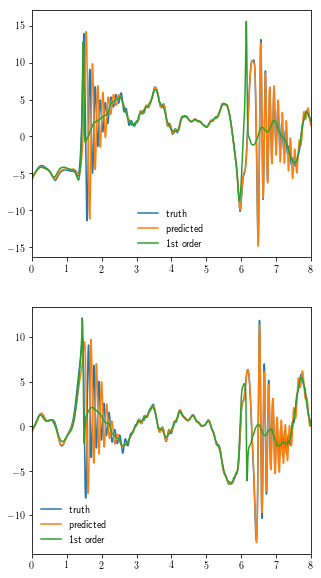

In [15]:
case = 17

figure, ax = plt.subplots(2, 1, figsize=(5,10))
ax[0].plot(np.arange(steps)*dt, v[steps0:, case, 0], label='truth')
ax[0].plot(np.arange(steps)*dt, Vp4[::2, case, 0], label='predicted')
ax[0].plot(np.arange(steps)*dt, vm_m[:, case, 0], label='1st order')
ax[0].set_xlim([0, steps*dt])
ax[0].set_label('$t$')
ax[0].legend(frameon=False)

ax[1].plot(np.arange(steps)*dt, v[steps0:, case, 1], label='truth')
ax[1].plot(np.arange(steps)*dt, Vp4[::2, case, 1], label='predicted')
ax[1].plot(np.arange(steps)*dt, vm_m[:, case, 1], label='1st order')
ax[1].set_xlim([0, steps*dt])
ax[1].set_label('$t$')
ax[1].legend(frameon=False)


## old model

In [35]:
class rnn_predictor_old(object):
    
    def __init__(self, input_dims, output_dims, lstm_units=128, dense_units=64,
                input_mean=0, input_std=1):
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.build_spinup(lstm_units, dense_units)
        self.build_step(lstm_units, dense_units)
        self.input_mean = input_mean
        self.input_std = input_std
        
    def build_spinup(self, lstm_units, dense_units):
        xi = layers.Input(shape=(None, self.input_dims))
        lstm_layer = layers.recurrent.LSTM(lstm_units, input_shape=(None, self.input_dims), return_state=True)
        out, *states = lstm_layer(xi)
        out = layers.Dropout(.2)(out)
#         out = layers.Dense(dense_units, activation='relu')(out)
        out = layers.Dense(dense_units)(out)
        out = layers.Dropout(.2)(out)
        out = layers.Dense(2, activation='linear')(out)
        self.models = Model(inputs=[xi], outputs=[out] + states)
        self.models.compile(optimizer='adam', loss='mse')
        
    def build_step(self, lstm_units, dense_units):
        xi = layers.Input(shape=(None, self.input_dims))
        states0 = [layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))]
        
        lstm_layer = layers.recurrent.LSTM(lstm_units, input_shape=(1, self.input_dims), return_state=True)
        out, *states = lstm_layer(xi, initial_state=states0)
        out = layers.Dropout(.2)(out)
#         out = layers.Dense(dense_units, activation='relu')(out)
        out = layers.Dense(dense_units)(out)
        out = layers.Dropout(.2)(out)
        out = layers.Dense(2, activation='linear')(out)
        self.model1 = Model(inputs=[xi]+states0, outputs=[out]+states)
        self.model1.compile(optimizer='adam', loss='mse')
    
    def load_weights(self, weights):
        self.models.load_weights(weights)
        self.model1.load_weights(weights)
    
    def spinup(self, inputs):
        return self.models.predict([inputs])
    
    def step(self, inputs):
        return self.model1.predict(inputs)
    

In [36]:
rpo = rnn_predictor_old(input_dims=4, output_dims=2, input_mean=feat_mean, input_std=feat_std)
weights = 'particle_results_organized/test2/weights/weights_800epochs_linear.h5'
rpo.load_weights(weights)

x_p, v_p, u_p, DuDt_p, vm_p, vt_p = rnn_predict(x0, v0, rpo, steps0//2, steps//2, mr, dt, t0, option=0)
x_p = np.mod(x_p, 2*np.pi)

## Compare results

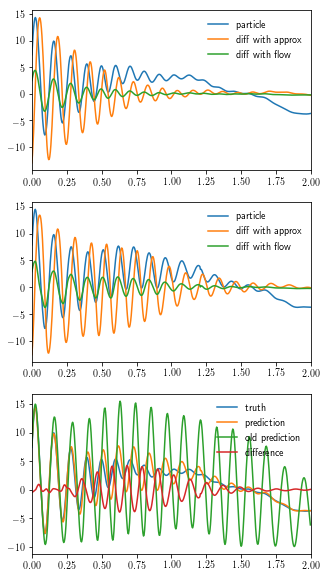

In [50]:
case = 7

figure, ax = plt.subplots(3, 1, figsize=(5,10))
ax[0].plot(np.arange(steps//2)*dt, v[steps0//2:, case, 0], label='particle')
ax[0].plot(np.arange(steps//2)*dt, v[steps0//2:, case, 0] - vm[steps0//2:, case, 0], label='diff with approx')
ax[0].plot(np.arange(steps//2)*dt, v[steps0//2:, case, 0] - u[steps0//2:, case, 0], label='diff with flow')
ax[0].set_xlim([0, steps*dt/2])
ax[0].set_label('$t$')
ax[0].legend(frameon=False)

ax[1].plot(np.arange(steps//2)*dt, Vp4[::2, case, 0], label='particle')
ax[1].plot(np.arange(steps//2)*dt, Vp4[::2, case, 0] - Vmp4[::2, case, 0], label='diff with approx')
ax[1].plot(np.arange(steps//2)*dt, Vp4[::2, case, 0] - Up4[::2, case, 0], label='diff with flow')
ax[1].set_xlim([0, steps*dt/2])
ax[1].set_label('$t$')
ax[1].legend(frameon=False)

ax[2].plot(np.arange(steps//2)*dt, v[steps0//2:, case, 0], label='truth')
ax[2].plot(np.arange(steps//2)*dt, Vp4[::2, case, 0], label='prediction')
ax[2].plot(np.arange(steps//2)*dt, v_p[:, case, 0], label='old prediction')
ax[2].plot(np.arange(steps//2)*dt, v[steps0//2:, case, 0] - Vp4[::2, case, 0], label='difference')
ax[2].set_xlim([0, steps*dt/2])
ax[2].set_label('$t$')
ax[2].legend(frameon=False)